# Kinematics of [S II]

I want to do a low-ionization line for comparison.  We already have a good handle on the sky correction for the [S II] doublet, at least when integrated over wavelength.

In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import astropy.units as u
import pandas as pd
sns.set_context("talk")
sns.set_color_codes()

In [2]:
datapath = Path("/Users/will/Work/Muse-Hii-Data/SMC-NGC-346/")
fitsfilepath = datapath / "ADP.2017-10-16T11_04_19.247.fits"
cube = Cube(str(fitsfilepath))

We start off, just like in the [O III] notebook:

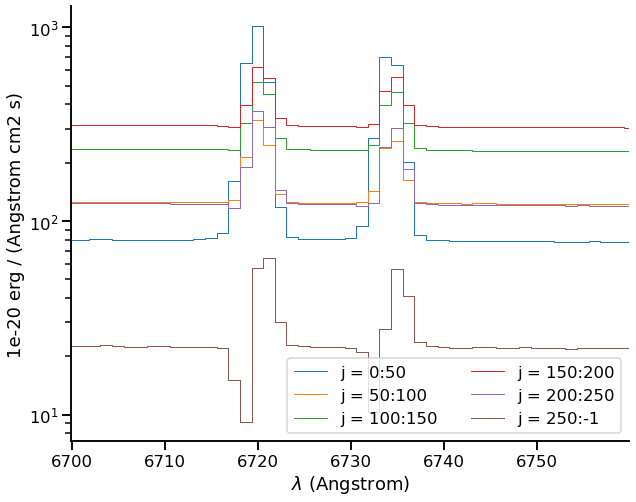

In [3]:
jstrips = [
    [0, 50], [50, 100], [100, 150], 
    [150, 200], [200, 250], [250, -1],
]
wide_band = cube.select_lambda(6700, 6760)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (wide_band[:, j1:j2, :]
     .mean(axis=(1, 2))
     .plot(label=f"j = {j1}:{j2}"))
ax.legend(ncol=2)
ax.set(yscale="log")
sns.despine();

In [5]:
wlim = {
    "6716": {
        "core": [6715.0, 6725.0],
        "blue": [6710.0, 6715.0],
        "red": [6725.0, 6730.0],
    },
    "6731": {
        "core": [6730.0, 6740.0],
        "blue": [6725.0, 6730.0],
        "red": [6740.0, 6745.0],
    }
}
rangecolors = {"core": "g", "blue": "b", "red": "r"}

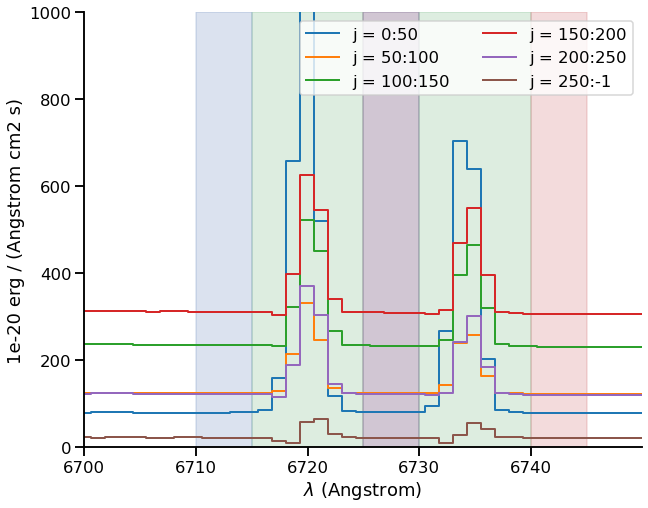

In [7]:
medium_band = cube.select_lambda(6700, 6750)
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    (medium_band[:, j1:j2, :]
     .mean(axis=(1, 2))
     .plot(label=f"j = {j1}:{j2}", linewidth=2))
    
for line, linedata in wlim.items():
    for span, spandata in linedata.items():
        ax.axvspan(
            spandata[0], spandata[1], 
            alpha=0.2, 
            color=rangecolors[span], 
            zorder=-100
        )
ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1000])
sns.despine();

In [8]:
def extract_core_and_cont(cube, spandata):
    """Return continuum-subtracted line core and continuum map
    
    The line core is a 3D cube over the narrow core wavelengths
    """
    cblue = cube.select_lambda(*spandata["blue"]).mean(axis=0)
    cred = cube.select_lambda(*spandata["red"]).mean(axis=0)
    cont = 0.5*(cblue + cred)
    core = cube.select_lambda(*spandata["core"]) - cont
    return core, cont

In [9]:
core6716, cont6716 = extract_core_and_cont(medium_band, wlim["6716"])
core6731, cont6731 = extract_core_and_cont(medium_band, wlim["6731"])

In [16]:
core6716.sum(axis=0).data.min()

-1519.1411865234359

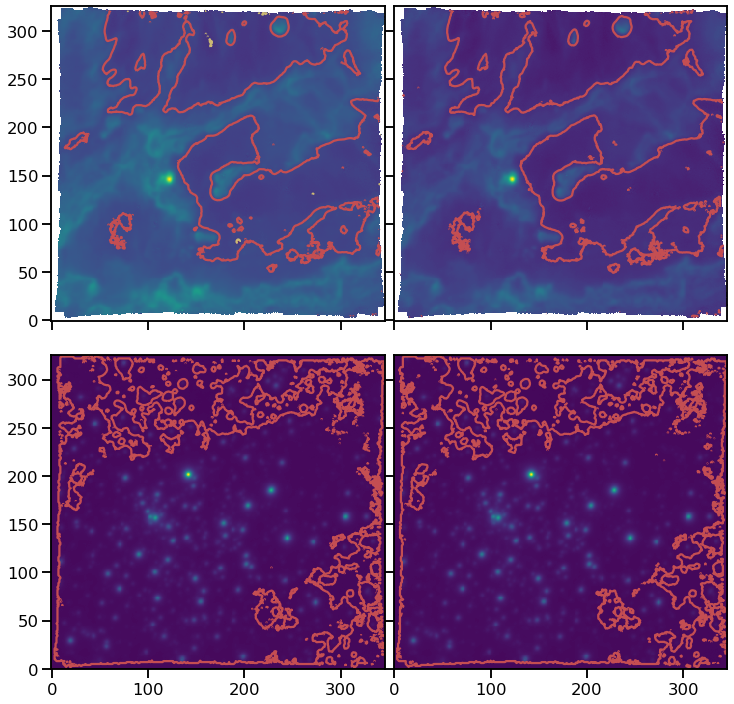

In [25]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(10, 10), 
    sharex=True, 
    sharey=True,
)
core6716.sum(axis=0).plot(
    ax=axes[0, 0], 
    scale="sqrt",
)
core6731.sum(axis=0).plot(
    ax=axes[0, 1],
    scale="sqrt",
)
cont6716.plot(ax=axes[1, 0], scale="sqrt")
cont6731.plot(ax=axes[1, 1], scale="sqrt")
axes[0, 0].contour(core6716.sum(axis=0).data, levels=[0.0], colors="r")
axes[0, 0].contour(
    core6716.sum(axis=0).data, 
    levels=[-800.0], 
    colors="y",
)
axes[0, 1].contour(core6731.sum(axis=0).data, levels=[0.0], colors="r")
axes[1, 0].contour(cont6716.data, levels=[0.0], colors="r")
axes[1, 1].contour(cont6731.data, levels=[0.0], colors="r")
fig.tight_layout(pad=0);

The distribution of negative pixels is different from with the high-ionization lines

In [28]:
np.where(
    (core6716.sum(axis=0).data < -800.0)
    & (core6716.sum(axis=0).data > -820.0)
)

(array([141, 284, 287, 288, 289, 289, 291, 294, 297, 317, 318, 318, 319]),
 array([340, 165, 166, 165, 165, 166, 164, 162, 160, 219, 219, 226, 219]))

Looks like we found the fully negative part to subtract:

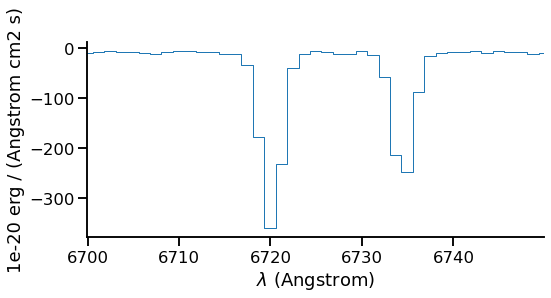

In [39]:
fig, ax = plt.subplots(figsize=(8,4))
skyspec_medium = medium_band[:, 287:289, 165:166].mean(axis=(1, 2))
skyspec_medium.plot()
fig.tight_layout()
sns.despine();

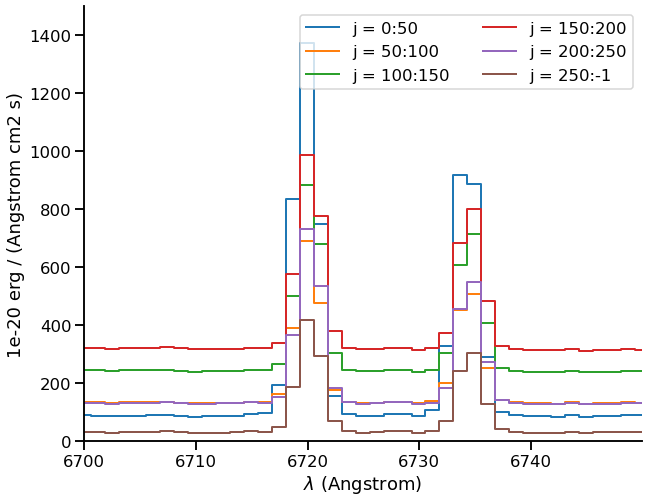

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
for (j1, j2) in jstrips:
    ((medium_band - skyspec_medium)[:, j1:j2, :]
     .mean(axis=(1, 2))
     .plot(label=f"j = {j1}:{j2}", linewidth=2))
    
ax.legend(ncol=2)
ax.set(yscale="linear", ylim=[0.0, 1500])
sns.despine();

In [42]:
skyspec6716 = core6716[:, 287:289, 165:166].mean(axis=(1, 2))
skyspec6731 = core6731[:, 287:289, 165:166].mean(axis=(1, 2))

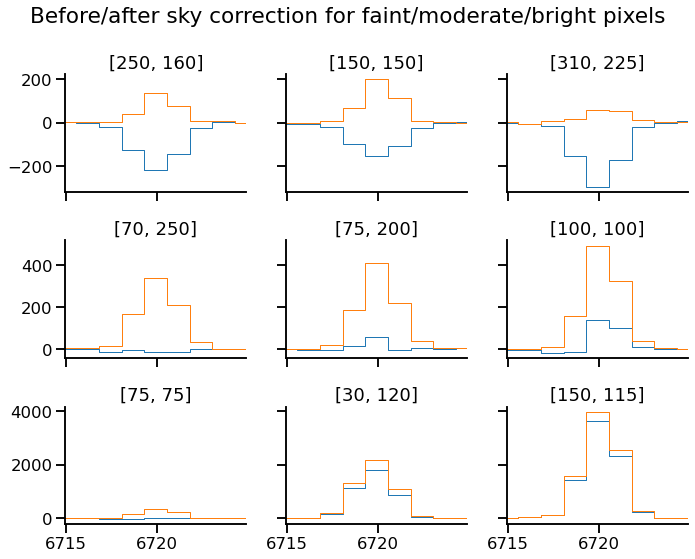

In [44]:
testpixels = [
    [250, 160], [150, 150], [310, 225],
    [70, 250], [75, 200], [100, 100],
    [75, 75], [30, 120], [150, 115], #[180, 290],
]
fig, axes = plt.subplots(
    3, 3, 
    figsize=(10, 8), 
    sharex=True,
    sharey="row",
)
for (j, i), ax in zip(testpixels, axes.flat):
    core6716[:, j, i].plot(ax=ax)
    (core6716[:, j, i] - skyspec6716).plot(ax=ax) 
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"[{j}, {i}]")
fig.suptitle(
    "Before/after sky correction for faint/moderate/bright pixels"
)
sns.despine()
fig.tight_layout();

In [47]:
def find_moments(cube):
    """
    Returns the normalized wavelength moments: mom0, mom1, mom2
    
    mom0 is sum over wavelength
    mom1 is mean wavelength
    mom2 is rms wavelength width
    """
    # TODO: calculate variance arrays
    wavcube = cube.clone(np.ones, np.zeros)
    wavcube.data *= cube.wave.coord()[:, None, None]
    wavcube.unit = u.angstrom
    # zeroth moment: sum
    mom0 = cube.sum(axis=0)
    # first moment: mean
    mom1 = mom0.copy()
    mom1.data = np.sum(
        cube.data * wavcube.data, 
        axis=0
    ) / mom0
    mom1.unit = u.angstrom
    # second moment: sigma
    mom2 = mom0.copy()
    mom2.data = np.sum(
        cube.data * (wavcube.data - mom1.data)**2, 
        axis=0
    ) / mom0
    mom2.data = np.sqrt(mom2.data)
    mom2.unit = u.angstrom
    return mom0, mom1, mom2

<ipython-input-47-38b764c34103>:28: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)
<ipython-input-47-38b764c34103>:28: RuntimeWarning: invalid value encountered in sqrt
  mom2.data = np.sqrt(mom2.data)


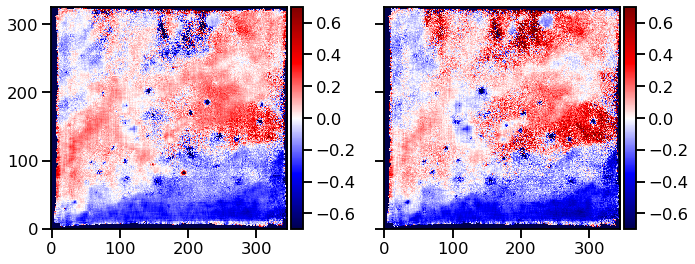

In [59]:
mom6716 = find_moments(core6716 - skyspec6716)
mom6731 = find_moments(core6731 - skyspec6731)
wav6716 = np.median(mom6716[1].data.data)
wav6731 = np.median(mom6731[1].data.data)
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 5),
    sharey=True,
)
(mom6716[1] - wav6716).plot(
    cmap="seismic",
    vmin=-0.7,
    vmax=+0.7,
    colorbar="v",
    ax=axes[0],
)
(mom6731[1] - wav6731).plot(
    cmap="seismic",
    vmin=-0.7,
    vmax=+0.7,
    colorbar="v",
    ax=axes[1],
)
fig.tight_layout();

These look great!

The only disagreement is in the low-intensity regions where the sky correction may need finessing. 

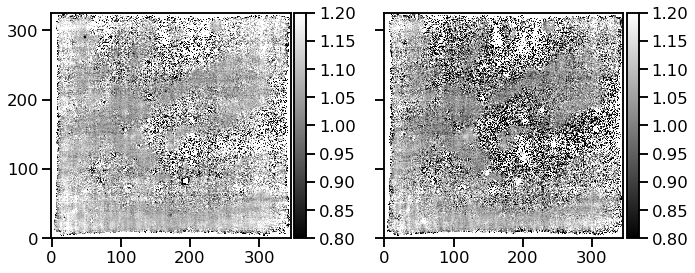

In [57]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(10, 5),
    sharey=True,
)
mom6716[2].plot(
    cmap="gray",
    vmin=0.8, 
    vmax=1.2,
    colorbar="v",
    ax=axes[0],
);
mom6731[2].plot(
    cmap="gray",
    vmin=0.8, 
    vmax=1.2,
    colorbar="v",
    ax=axes[1],
);
fig.tight_layout();

In [76]:
mom0 = mom6716[0]
mom1 = mom6716[1]
mom2 = mom6716[2]
rest6716 = 6716.44
m = (mom6716[0].mask 
     | (mom0.data < 60)
     | (mom1.data < wav6716 - 0.6) 
     | (mom1.data > wav6716 + 0.6)
     | (mom2.data < 0.8)
     | (mom2.data > 1.5)
    )
df = pd.DataFrame({
    "log10 I(6716)": np.log10(mom0.data[~m]),
    "V(6716)": 3e5 * (mom1.data[~m] - rest6716) / rest6716,
    "sig(6716)": 3e5 * mom2.data[~m] / rest6716,
})
df.describe()

,log10 I(6716),V(6716),sig(6716)
count,99613.000000,99613.000000,99613.000000
mean,3.062810,162.743548,49.107170
std,0.329097,7.257567,4.477664
min,1.782353,136.463345,35.738024
25%,2.834714,158.213749,46.633910
50%,3.068120,163.952002,48.805362
75%,3.307587,167.735281,51.278406
max,4.507707,189.904639,66.994963


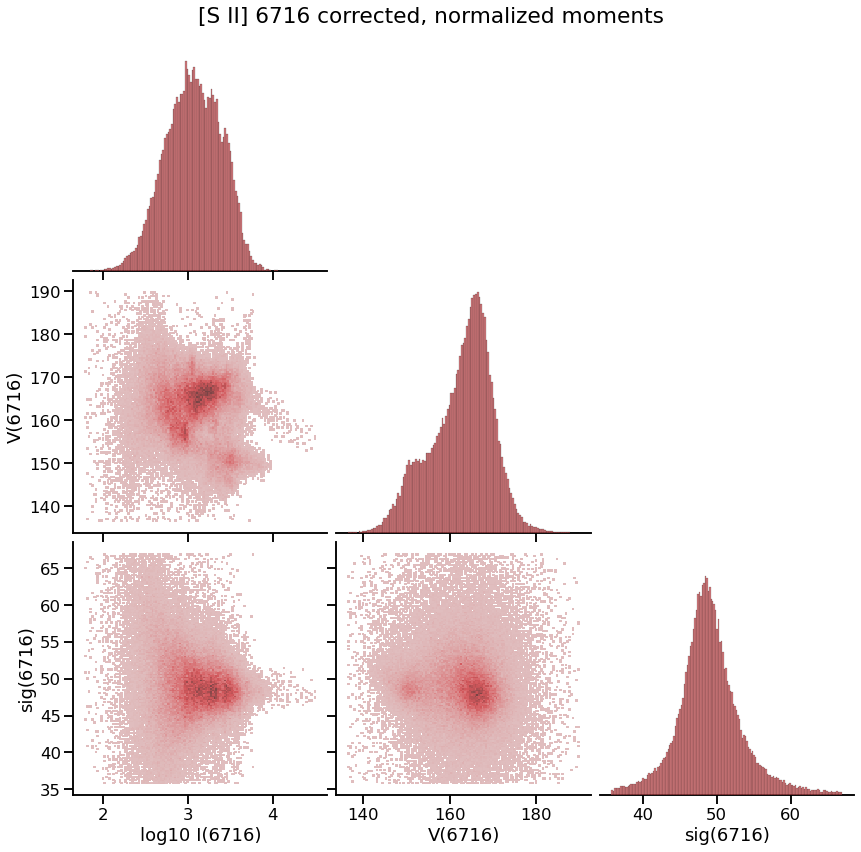

In [77]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[S II] 6716 corrected, normalized moments")
g.tight_layout(pad=0);

This shows some interesting structure in the I-V distribution. We see the same two velocity components of [O III] (158 and 164), plus an additional one at 150 (which is very weak in [O III])

In [78]:
mom0 = mom6716[0].rebin(2)
mom1 = mom6716[1].rebin(2)
mom2 = mom6716[2].rebin(2)
rest6716 = 6716.44
m = (mom0.mask 
     | (mom0.data < 60)
     | (mom1.data < wav6716 - 0.6) 
     | (mom1.data > wav6716 + 0.6)
     | (mom2.data < 0.8)
     | (mom2.data > 1.5)
    )
df = pd.DataFrame({
    "log10 I(6716)": np.log10(mom0.data[~m]),
    "V(6716)": 3e5 * (mom1.data[~m] - rest6716) / rest6716,
    "sig(6716)": 3e5 * mom2.data[~m] / rest6716,
})
df.describe()

,log10 I(6716),V(6716),sig(6716)
count,25859.000000,25859.000000,25859.000000
mean,3.048820,162.749706,48.888835
std,0.339239,6.975427,3.603135
min,1.788655,136.485674,35.753498
25%,2.815983,158.488275,47.010010
50%,3.058029,163.960333,48.622624
75%,3.301779,167.519881,50.532281
max,4.474710,189.653273,66.989990


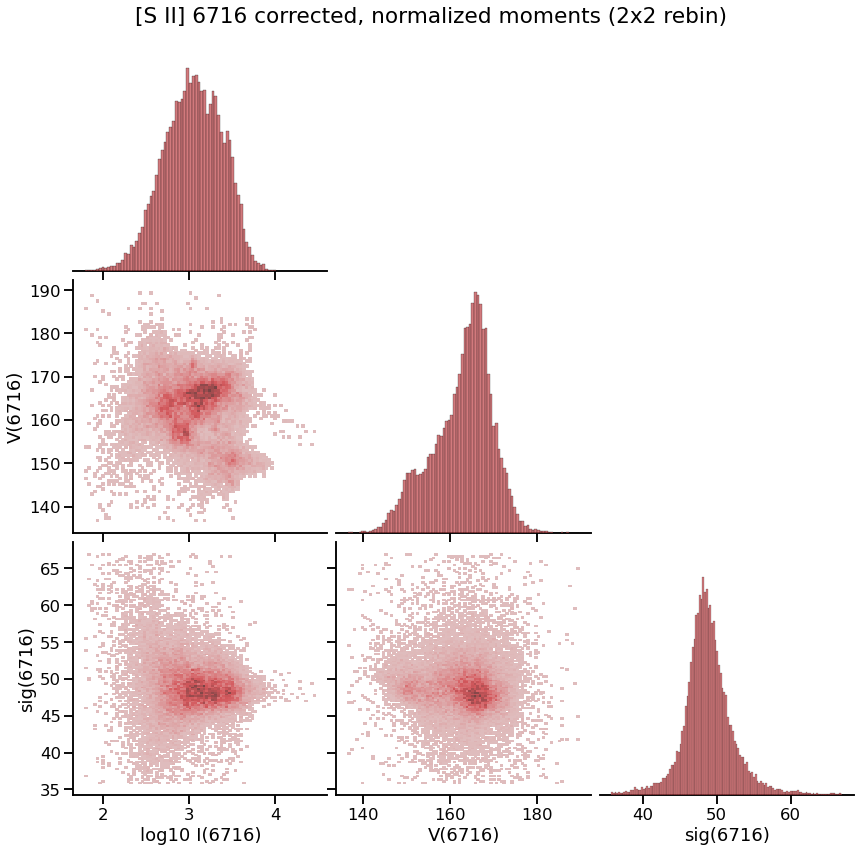

In [79]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
    plot_kws=dict(color="r"),
    diag_kws=dict(color="r"),
)
g.fig.suptitle("[S II] 6716 corrected, normalized moments (2x2 rebin)")
g.tight_layout(pad=0);

Rebinning doesn't help as much as I had hoped.  But it does reduce the spread in the sigma for the lower intensities.